In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from datetime import datetime

import time 
#Neural Nets
import tensorflow as tf

# Add the parent directory to the Python path to allow imports from tests/
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from dotenv import load_dotenv

from mkt_data_ETL.data_load_and_transform import get_data, get_top_mkt_cap_stocks


import warnings
import random

load_dotenv()
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:

# =============================================================================
# REPRODUCIBILITY SETUP - Set seeds for deterministic results
# =============================================================================
def set_seeds(seed=42):
    """
    Set seeds for reproducible results across all random number generators.
    
    Args:
        seed (int): The seed value to use for all random number generators
    """
    # Set Python's built-in random seed
    random.seed(seed)
    
    # Set NumPy seed
    np.random.seed(seed)
    
    # Set TensorFlow seeds
    tf.random.set_seed(seed)
    
    # Set environment variables for deterministic behavior
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Configure TensorFlow for deterministic operations
    tf.config.experimental.enable_op_determinism()
    
    print(f"All seeds set to: {seed}")
    print("Deterministic operations enabled for reproducible results.")

# Set the seed for reproducible results
SEED = 42
set_seeds(SEED)

def verify_seed_settings():
    """
    Verify that all seed settings are properly configured.
    This function can be called to check reproducibility setup.
    """
    print("=== Reproducibility Verification ===")
    print(f"SEED value: {SEED}")
    print(f"PYTHONHASHSEED: {os.environ.get('PYTHONHASHSEED', 'Not set')}")
    print(f"TF_DETERMINISTIC_OPS: {os.environ.get('TF_DETERMINISTIC_OPS', 'Not set')}")
    print(f"TF_CUDNN_DETERMINISTIC: {os.environ.get('TF_CUDNN_DETERMINISTIC', 'Not set')}")
    print("=====================================")

# Uncomment the line below to verify seed settings
# verify_seed_settings()

All seeds set to: 42
Deterministic operations enabled for reproducible results.


In [3]:
# Get data 
stock_prices_df, stock_shares_amount_df, mkt_cap_df, spx_index, removed_companies = get_data()
top_100_mkt_cap_df, top_100_mkt_cap_prices_df=get_top_mkt_cap_stocks(stock_prices_df=stock_prices_df, 
stock_mkt_cap_df=mkt_cap_df)


# Calculate daily returns
stocks_returns    = np.log(top_100_mkt_cap_prices_df / top_100_mkt_cap_prices_df.shift(1))
sp500_idx_returns =  np.log(spx_index / spx_index.shift(1))

# Rolling volatility
window_size = 252*2 # 2 years
Sigma_df= stocks_returns.rolling(window=window_size).cov(pairwise=True)
Sigma_df = Sigma_df.dropna()

# Get the first date in the cleaned DataFrame
START_DATE = Sigma_df.index.get_level_values(0)[0]

# Filter dataframes to start from START_DATE
top_100_mkt_cap_df = top_100_mkt_cap_df.loc[START_DATE:]
stocks_returns     = stocks_returns.loc[START_DATE:]
stock_prices_df    = stock_prices_df.loc[START_DATE:]

assets = stocks_returns.columns
dates  = stocks_returns.index

n = len(assets)
T = len(dates)
Sigma_t = np.empty((T, n, n))

# Fill array with each rolling covariance matrix
for i, t in enumerate(dates):
    Sigma = Sigma_df.loc[t].reindex(index=assets, columns=assets).values
    Sigma_t[i] = Sigma


# Mkt Weights
mkt_portfolio_weights = top_100_mkt_cap_df.div(top_100_mkt_cap_df.sum(axis=1),axis=0)

#Retorno do portfólio de mercado
mkt_return = (mkt_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)

In [4]:
def compute_relative_covariance(sigma: np.ndarray, pi: np.ndarray) -> np.ndarray:
    """
    Calcula a matriz de covariância relativa τ_ij^π(t) com base na covariância σ_ij(t)
    e no vetor de pesos do portfólio π(t).
    
    Args:
        sigma (np.ndarray): Matriz de covariância dos ativos (n x n).
        pi (np.ndarray): Vetor de pesos do portfólio (n,).

    Returns:
        np.ndarray: Matriz de covariância relativa τ^π (n x n).
    """
    # Covariância ativo i com portfólio: sigma_iπ = sigma @ pi
    sigma_i_pi = sigma @ pi        # (n,)
    sigma_pi_pi = pi.T @ sigma @ pi  # escalar

    # Matriz τ_ij^π = σ_ij - σ_iπ - σ_jπ + σ_ππ
    n = len(pi)
    tau = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            tau[i, j] = sigma[i, j] - sigma_i_pi[i] - sigma_i_pi[j] + sigma_pi_pi
    return tau

print("initializing tau_t calculation")
start_time = time.time()

tau_t = np.empty((T, n, n))
for t in range(T):
    tau_t[t] = compute_relative_covariance(Sigma_t[t], mkt_portfolio_weights.iloc[t].values)

end_time = time.time()
elapsed_seconds = end_time - start_time
print(f"Elapsed time: {elapsed_seconds:.2f} seconds")


# Copying data generated previously 
mu_t_df = mkt_portfolio_weights.copy()
R_t_df =  stocks_returns.copy()
 
mu_tf                   = tf.convert_to_tensor(mu_t_df.values, dtype=tf.float32) # Pesos de mercado
mkt_ret_tf              = tf.convert_to_tensor(mkt_return.values, dtype=tf.float32)              # Retorno do portfólio de mercado
R_t_tf                  = tf.convert_to_tensor(R_t_df.values, dtype=tf.float32)
tau_t_tf                = tf.convert_to_tensor(tau_t, dtype=tf.float32)


indices = np.arange(len(mu_tf))
train_idx, test_idx = train_test_split(indices, test_size=0.1, shuffle=False, random_state=SEED)

# Split datasets

#Treino
mu_train            = tf.gather(mu_tf, train_idx)
mkt_ret_train       = tf.gather(mkt_ret_tf, train_idx)
stock_returns_train = tf.gather(R_t_tf, train_idx)
tau_train           = tf.gather(tau_t_tf, train_idx)

# Teste
mu_test            = tf.gather(mu_tf, test_idx)
mkt_ret_test       = tf.gather(mkt_ret_tf, test_idx)
stock_returns_test = tf.gather(R_t_tf,  test_idx)
tau_test           = tf.gather(tau_t_tf, test_idx)

initializing tau_t calculation
Elapsed time: 11.41 seconds


In [5]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim=100):
        """
        Inicializa o modelo PINN com uma arquitetura otimizada para aprender
        funções suaves (C^2) e côncavas.

        Args:
            input_dim (int): A dimensionalidade da entrada da rede (padrão: 200).
        """
        super(PINN, self).__init__()

        self.lambda1 = tf.Variable(initial_value=1.0, trainable=False, dtype=tf.float32)
        self.lambda2 = tf.Variable(initial_value=1.0, trainable=False, dtype=tf.float32)
        
        initializer = tf.keras.initializers.GlorotNormal(seed=SEED)
        l2_regularizer = tf.keras.regularizers.l2(0.001)

        # O corpo principal da rede é definido usando tf.keras.Sequential
        # para maior clareza e manutenibilidade.
        self.hidden_layers = tf.keras.Sequential([
            # Camada de Entrada
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            
            # Bloco Oculto 1
            # Usamos 'swish' por ser suave (C^∞) e ter ótimo desempenho.
            # A arquitetura de largura constante (128 neurônios) é robusta.
            tf.keras.layers.Dense(100, activation='swish', kernel_initializer=initializer),
            
            # Bloco Oculto 2
            tf.keras.layers.Dense(100, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
            
            # Bloco Oculto 3
            tf.keras.layers.Dense(100, activation='swish', kernel_initializer=initializer, kernel_regularizer=l2_regularizer),
            # Nota: Dropout foi removido para garantir derivadas mais estáveis.
        ])
        
        # A camada de saída permanece a mesma, pois 'softplus' garante G > 0.
        self.output_layer = tf.keras.layers.Dense(1, activation='softplus')

    @tf.function
    def call(self, inputs):
        """
        Executa a passagem para a frente (forward pass).
        A lógica de separação e concatenação foi removida por ser redundante.
        """
        z = self.hidden_layers(inputs)
        return self.output_layer(z)

In [6]:
def custom_loss(model, x, ret, ret_mkt, tau):
    """
    Custom loss function for the PINN.

    Args:
        model (PINN): The PINN model.
        x (tf.Tensor): Market weights.
        ret (tf.Tensor): Stock returns.
        ret_mkt (tf.Tensor): The market return.
        tau (tf.Tensor): Relative covariance matrix.

    Returns:
        _type_: Loss value and metrics.
    """

    ###############################
    # # Derivatives Calculation # #  
    ###############################
    try: 
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(x)
                G_x_pred = model(x)  
                log_G_x_pred = tf.math.log(G_x_pred + 1e-7)
            
            grad_log_G_X = tape1.gradient(log_G_x_pred, x)
            grad_G       = tape1.gradient(G_x_pred, x)  # ∇G(x)

        H_G = tape2.batch_jacobian(grad_G, x)  # ∇²G(x) - Hessian

        ###################################################################################
        # # Functionally Generated Portfolio - Generated by the Neural Network function # #
        ###################################################################################

        inner_prod = tf.reduce_sum(x * grad_log_G_X, axis=1)
        pi_t = ((grad_log_G_X + 1) - tf.expand_dims(inner_prod, axis=1))*x

        # Shift weights to consider trade date at the end of the day
        pi_t_shifted = tf.concat([pi_t[:1], pi_t[:-1]], axis=0)

        # Portfolio return
        port_ret = tf.reduce_sum(pi_t_shifted * ret, axis=1)


        #########################
        # # Drift Calculation # #
        #########################
        T = tf.shape(pi_t)[0]

        mu_i = tf.expand_dims(x, axis=2)     # (T, n, 1)
        mu_j = tf.expand_dims(x, axis=1)     # (T, 1, n)

        # internal product μ_i μ_j: shape (T, n, n)
        mu_outer = mu_i * mu_j

        # elementwise: H * μ_i * μ_j * τ
        elementwise = H_G * mu_outer * tau  # shape (T, n, n)

        # sum over i and j (last two dimensions)
        summed = tf.reduce_sum(elementwise, axis=[1, 2])  # shape (T,)

        # Drift final: -1 / (2G) * sum
        dg_t = -0.5 * summed / G_x_pred


        # #########################
        # # # Drift integration # #
        # #########################
        base = tf.range(T)

        # Conditional: trapezoid if T % 2 == 0, Simpson otherwise
        # g_t = tf.cond(
        #     tf.equal(T % 2, 0),
        #     lambda: tf.reduce_sum(
        #         tf.cast(tf.where((base == 0) | (base == T - 1), 0.5, 1.0), dg_t.dtype) * dg_t
        #     ),
        #     lambda: (1.0 / 3.0) * tf.reduce_sum(
        #         tf.cast(tf.where(base == 0, 1.0,
        #             tf.where(base == T - 1, 1.0,
        #             tf.where(base % 2 == 0, 2.0, 4.0))), dg_t.dtype) * dg_t
        #     )
        # )

        weights = tf.ones_like(dg_t, dtype=dg_t.dtype)
        if T % 2 == 1:  
            weights = tf.where(
                (base % 2 == 1) & (base != 0) & (base != T-1),
                tf.constant(4.0, dtype=dg_t.dtype),
                weights
            )
            weights = tf.where(
                (base % 2 == 0) & (base != 0) & (base != T-1),
                tf.constant(2.0, dtype=dg_t.dtype),
                weights
            )
            weights *= (1.0 / 3.0)
        else:  # Trapezoidal rule
            weights = tf.where(
                (base == 0) | (base == T-1),
                tf.constant(0.5, dtype=dg_t.dtype),
                tf.constant(1.0, dtype=dg_t.dtype)
            )
        g_t = tf.reduce_sum(weights * dg_t)

        # #######################
        # # # Master Eq Error # #
        # #######################

        eps = 1e-6

        G0 = tf.clip_by_value(G_x_pred[0], clip_value_min=eps, clip_value_max=1e6)
        GT = tf.clip_by_value(G_x_pred[-1], clip_value_min=eps, clip_value_max=1e6)
        right_hand_side = tf.math.log(G0[0]) - tf.math.log(GT[0]) + g_t


        # Cumulative log return
        port_cumulative_return = tf.math.exp(tf.reduce_sum(port_ret))
        mkt_cumulative_return = tf.math.exp(tf.reduce_sum(ret_mkt))
        left_hand_side = tf.math.log(port_cumulative_return) - tf.math.log(mkt_cumulative_return)

        equation_error = tf.square(left_hand_side - right_hand_side)  # Smooth, differentiable
        positivity_penalty = tf.square(tf.nn.relu(-g_t))  # Only penalizes when negative


        return equation_error, positivity_penalty, grad_G, pi_t, g_t, {
                'grad_log_G_X_norm': tf.norm(grad_G, ord='euclidean', axis=1),
                'portfolio_weights': pi_t,
                'integrated_drift': g_t,
            }
    finally:
        if tape1 is not None:
            del tape1
        if tape2 is not None:
            del tape2

In [7]:
batch_size = 63
dataset = tf.data.Dataset.from_tensor_slices(
    (mu_train, stock_returns_train, mkt_ret_train, tau_train)
).batch(batch_size)

# Model Compilation
# Note: Seeds have been set for reproducible results
model = PINN(input_dim=100)
epoch_bounds = [500]
lr_values = [1e-2, 1e-3]
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(epoch_bounds, lr_values)
optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9, beta_2=0.95)


###########################################################
## Vetores para armazenamento de métricas de Treinamento ##
###########################################################
avg_epoch_loss_vect = []

grad_norms_per_epoch = {}
mkt_weights_per_epoch = {}
drift_per_epoch = {}

grad_norms_batch_vect     = []
mkt_weights_per_batch_vect = []
drift_per_batch_vect = []

# Training loop (batches processed in sequence)
num_epochs = 15
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    for x_batch, ret_batch, ret_mkt_batch, tau_batch in dataset:
        with tf.GradientTape(persistent=True) as tape:
            # loss_value, metrics_dics = custom_loss(model, x_batch, ret_batch, ret_mkt_batch, tau_batch)
            eq_err, pos_penalty, grad_G, pi_t, g_t, metrics_dics = custom_loss(model, x_batch, ret_batch, ret_mkt_batch, tau_batch)
            L1 = eq_err
            L2 = pos_penalty
            total_loss = tf.stop_gradient(model.lambda1) * L1 + tf.stop_gradient(model.lambda2) * L2


        epsilon = 1e-8
        grads_L1 = tape.gradient(L1, model.trainable_variables)
        grads_L2 = tape.gradient(L2, model.trainable_variables)

        norm_L1 = tf.sqrt(tf.add_n([tf.reduce_sum(tf.square(g)) for g in grads_L1 if g is not None]))
        norm_L2 = tf.sqrt(tf.add_n([tf.reduce_sum(tf.square(g)) for g in grads_L2 if g is not None]))
        total_norm = norm_L1 + norm_L2 + epsilon

        lambda1_new = total_norm / (norm_L1 + epsilon)
        lambda2_new = total_norm / (norm_L2 + epsilon)

        alpha = 0.9
        model.lambda1.assign(alpha * model.lambda1 + (1 - alpha) * lambda1_new)
        model.lambda2.assign(alpha * model.lambda2 + (1 - alpha) * lambda2_new)

        total_grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(total_grads, model.trainable_variables))
        
        del tape


        grad_norms_batch_vect = grad_norms_batch_vect + metrics_dics['grad_log_G_X_norm'].numpy().tolist()
        mkt_weights_per_batch_vect = mkt_weights_per_batch_vect + metrics_dics['portfolio_weights'].numpy().tolist()
        drift_per_batch_vect.append(metrics_dics['integrated_drift'].numpy())

        epoch_loss += total_loss.numpy()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    
    avg_epoch_loss_vect.append(avg_epoch_loss)
    grad_norms_per_epoch[str(epoch)]  = grad_norms_batch_vect
    mkt_weights_per_epoch[str(epoch)]  = mkt_weights_per_batch_vect
    drift_per_epoch[str(epoch)]  = drift_per_batch_vect

    grad_norms_batch_vect     = []
    mkt_weights_per_batch_vect = []
    drift_per_batch_vect = []

    # Print average Epoch loss
    if epoch % 1==0:
         print(f"Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_epoch_loss:.6f}, lambda 1: {model.lambda1.numpy():.4f}, lambda 2: {model.lambda2.numpy():.4f}")

print(f"Final Avg Loss: {avg_epoch_loss:.6f}")


Epoch 1/15, Avg Loss: 0.000176, lambda 1: 1.0000, lambda 2: 18339.3262
Epoch 2/15, Avg Loss: 0.000341, lambda 1: 1.0000, lambda 2: 7962.1196
Epoch 3/15, Avg Loss: 0.000138, lambda 1: 1.0000, lambda 2: 6010.5898
Epoch 4/15, Avg Loss: 0.000094, lambda 1: 1.0000, lambda 2: 30160.3359
Epoch 5/15, Avg Loss: 0.000290, lambda 1: 1.0000, lambda 2: 9703.9277
Epoch 6/15, Avg Loss: 0.000728, lambda 1: 1.0000, lambda 2: 30397.8242
Epoch 7/15, Avg Loss: 0.000987, lambda 1: 1.0000, lambda 2: 11035.2627
Epoch 8/15, Avg Loss: 0.000162, lambda 1: 1.0000, lambda 2: 4445.2695
Epoch 9/15, Avg Loss: 0.000089, lambda 1: 1.0000, lambda 2: 1430.9934
Epoch 10/15, Avg Loss: 0.000005, lambda 1: 1.0000, lambda 2: 246.0976
Epoch 11/15, Avg Loss: 0.000009, lambda 1: 1.0000, lambda 2: 509.1051
Epoch 12/15, Avg Loss: 0.000008, lambda 1: 1.0000, lambda 2: 465.2479
Epoch 13/15, Avg Loss: 0.000007, lambda 1: 1.0000, lambda 2: 452.1100
Epoch 14/15, Avg Loss: 0.000005, lambda 1: 1.0000, lambda 2: 289.4855
Epoch 15/15, Avg

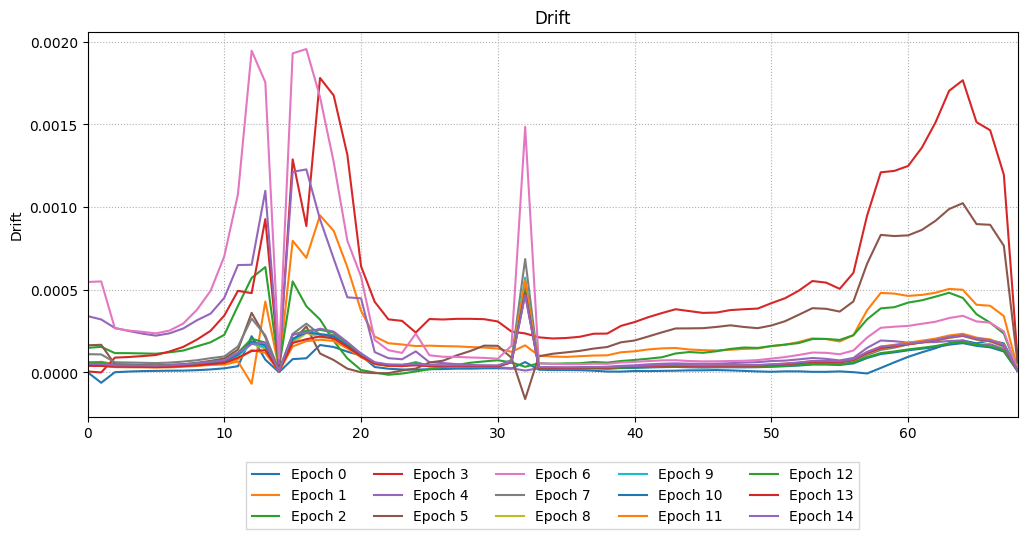

In [8]:
plt.figure(figsize=(12, 5))

keys = list(drift_per_epoch.keys())
step = max(1, len(keys) // 10)  # Plot only 10% of the curves

for idx in range(0, len(keys), step):
    i = keys[idx]
    plt.plot(drift_per_epoch[i], label=f'Epoch {i}')

plt.title('Drift Series along the Batches')
plt.ylabel('Drift')
plt.grid(linestyle=':')
plt.margins(x=0)
plt.xlabel(None)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=5)
plt.show()

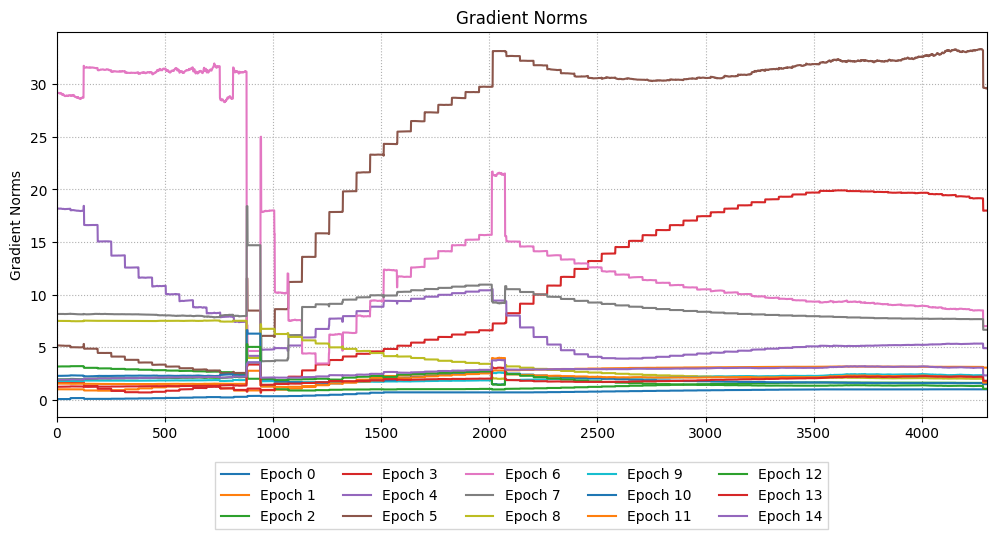

In [9]:
plt.figure(figsize=(12, 5))

# Get all keys and calculate step size for 10% intervals
keys = list(grad_norms_per_epoch.keys())
step = max(1, len(keys) // 10)  # Ensure at least 1, but aim for 10 curves

# Plot only every step-th key
for idx in range(0, len(keys), step):
    i = keys[idx]
    plt.plot(grad_norms_per_epoch[i], label=f'Epoch {i}')

plt.grid(linestyle=':')
plt.margins(x=0)
plt.xlabel(None)
plt.title('Gradient Norms')
plt.ylabel('Gradient Norms')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=5)
plt.show()

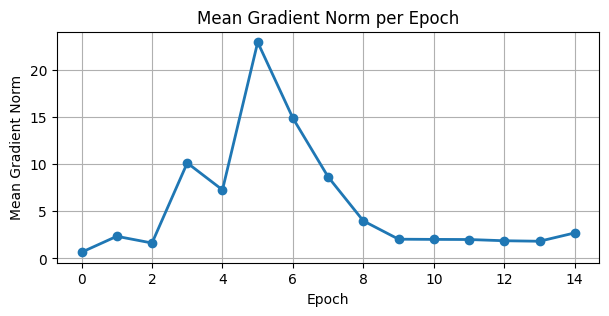

In [10]:
# Second chart: Mean gradient norm per epoch
plt.figure(figsize=(7, 3))

# Calculate mean gradient norm for each epoch
epoch_means = []
epoch_numbers = []

for key in grad_norms_per_epoch.keys():
    epoch_means.append(np.mean(grad_norms_per_epoch[key]))
    epoch_numbers.append(int(key))

plt.plot(epoch_numbers, epoch_means, marker='o', linewidth=2, markersize=6)
plt.title('Mean Gradient Norm per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Gradient Norm')
plt.grid(True)
plt.show()

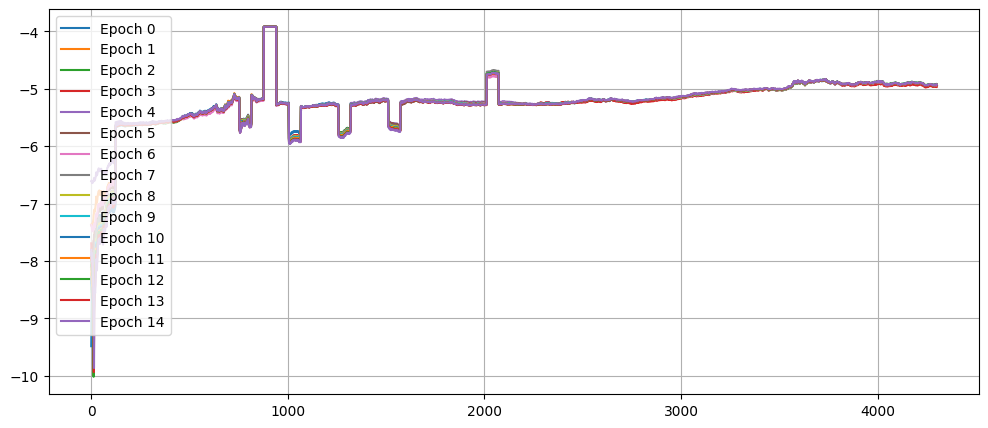

In [11]:
plt.figure(figsize=(12, 5))

keys = list(mkt_weights_per_epoch.keys())
step = max(1, len(keys) // 10)  # Plot only 10% of the curves

for idx in range(0, len(keys), step):
    i = keys[idx]
    plt.plot(
        np.log(np.mean(np.abs(mu_train.numpy()[int(i)] - mkt_weights_per_epoch[i]), axis=1)),
        label=f'Epoch {i}'
    )

plt.legend()
plt.grid(True)
plt.show()

## Network Performance Analysis

In [12]:
from performance_metrics import plot_avg_epoch_loss
from performance_metrics import plot_G_nn_with_test_highlight, plot_cumulative_portfolios_performance
from performance_metrics import  calculate_dwp_portfolio_return, calculate_model_portfolio_return


target_vol = 0.1
p_value = 0.5
model_return = calculate_model_portfolio_return(model, mu_tf, R_t_tf)
dwp_return   = calculate_dwp_portfolio_return(mkt_portfolio_weights, stocks_returns, p_value)

dates = stocks_returns.index 

series_dict = {
    'Market': mkt_return.values,
    'Model': model_return.numpy().flatten(),
    'DWP': dwp_return.values
}


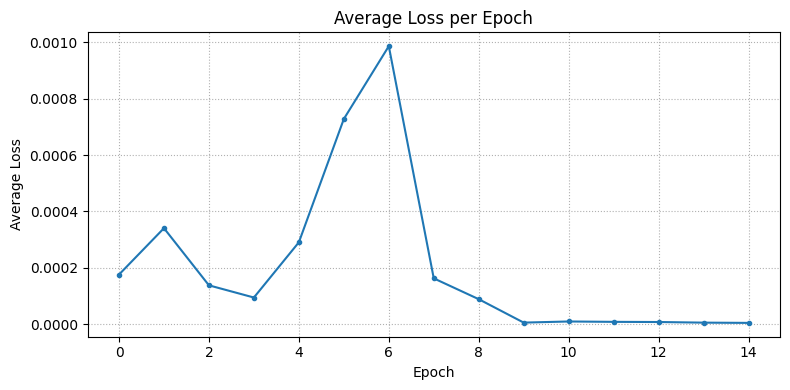

In [13]:
plot_avg_epoch_loss(avg_epoch_loss_vect)

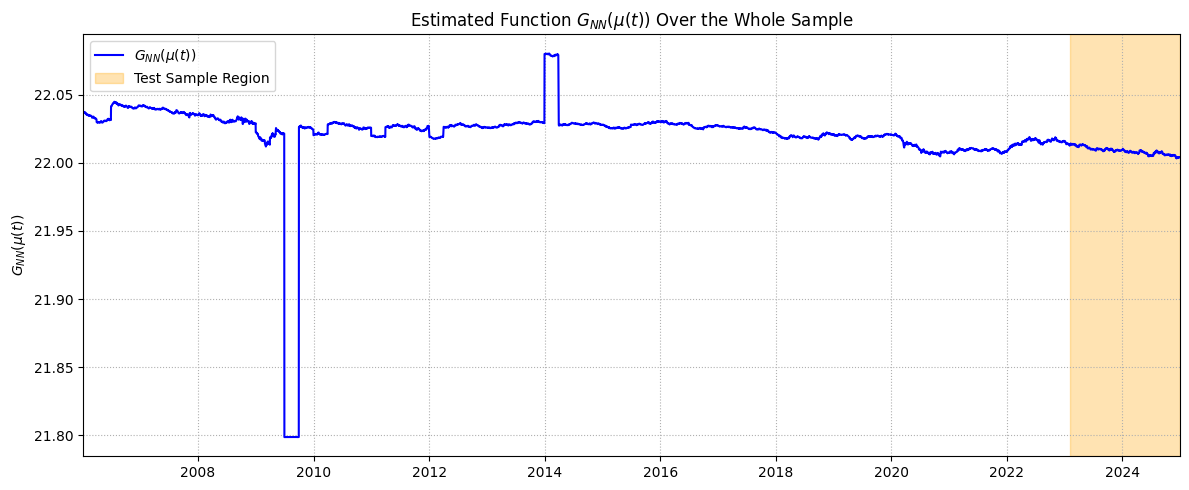

In [ ]:
plot_G_nn_with_test_highlight(
    model=model,
    mu_tf=mu_tf,
    R_t_tf=R_t_tf,
    test_idx=test_idx,
    dates=dates
)

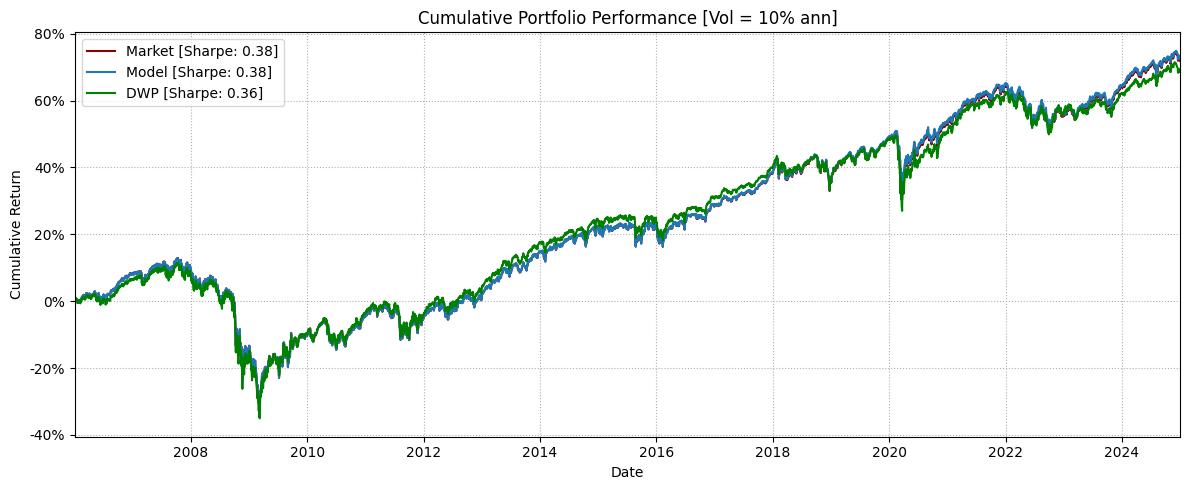

In [ ]:
plot_cumulative_portfolios_performance(series_dict, dates, target_vol=0.1)